# Experimental Results: Comparison of Dimensionality Reduction Methods

This notebook implements the experimental comparison of four dimensionality reduction methods 
(t-SNE, LLE, ISOMAP, and MDS) on synthetic and real-world datasets. It generates all figures 
and tables used in the accompanying article.

Key Components:
1. Implementation of quality metrics (trustworthiness, continuity, classification consistency)
2. Generation of visualizations for all method-dataset combinations
3. Computation of comparative tables using LaTeX format
4. Storage of results in pickle files for reproducibility

Pre-optimized parameters from previous experiments are used for LLE and ISOMAP.
For detailed explanations of metrics and methodology, please refer to the article.

In [260]:
# -----------------------------------------------------------------------------
import plot
import metrics
import data_utils
from importlib import reload
import config

reload(plot)
reload(metrics)
reload(data_utils)

from metrics import evaluate_methods_on_datasets, aggregate_metrics
from plot import plot_all_methods_and_datasets
from data_utils import DatasetManager, load_datasets


# Synthetic data

## Application of dimensionality reduction methods

In [174]:
dataset_name = 'sample_data.pkl'
save_path = config.DATA_DIR

manager = DatasetManager(dataset_name, save_path, load_datasets)
datasets = manager.load_dataset()

best_isomap =  {'Helicoids':36, 'Zigzag':12, 'Swiss Roll':35, 'Bonhomme':89}
best_lle = {'Helicoids':64, 'Zigzag':54, 'Swiss Roll':55, 'Bonhomme':41}

results = evaluate_methods_on_datasets(best_isomap, best_lle, datasets)
aggregated_results = aggregate_metrics(results)

#save the results
import pickle
# Assuming results and aggregated_results are correctly computed:
data_to_save = {'results': results, 'aggregated_results': aggregated_results}
with open(f'{config.DATA_DIR}/results_synthetic.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


Loading sample_data.pkl from local storage.


In [184]:
datasets['Zigzag']

(array([[ 4.96714153e-03, -1.38264301e-03,  6.47688538e-03],
        [ 2.12543949e-02,  9.70665902e-03, -2.34136957e-03],
        [ 2.78403209e-02,  3.17707328e-02, -4.69474386e-03],
        ...,
        [ 1.06373654e+00,  2.03804269e+00,  1.98495928e+00],
        [ 1.04104719e+00,  2.01466522e+00,  1.99477863e+00],
        [ 1.04608865e+00,  1.99427503e+00,  1.98547731e+00]]),
 array([0.        , 0.00120627, 0.00241255, 0.00361882, 0.00482509,
        0.00603136, 0.00723764, 0.00844391, 0.00965018, 0.01085645,
        0.01206273, 0.013269  , 0.01447527, 0.01568154, 0.01688782,
        0.01809409, 0.01930036, 0.02050663, 0.02171291, 0.02291918,
        0.02412545, 0.02533172, 0.026538  , 0.02774427, 0.02895054,
        0.03015682, 0.03136309, 0.03256936, 0.03377563, 0.03498191,
        0.03618818, 0.03739445, 0.03860072, 0.039807  , 0.04101327,
        0.04221954, 0.04342581, 0.04463209, 0.04583836, 0.04704463,
        0.0482509 , 0.04945718, 0.05066345, 0.05186972, 0.053076  ,
       

In [175]:
import os
file_path = f'{config.DATA_DIR}/results_synthetic.pkl'
print(os.path.getsize(file_path))

1774


In [176]:
with open(f'{config.DATA_DIR}/results_synthetic.pkl', 'rb') as f:
    data = pickle.load(f)
results = data["results"]
aggregated_results = data["aggregated_results"]



## Print the latex table of the results

In [177]:
def print_latex_table_aggregated(aggregated_results, label=""):
    """
    The aggregated results table highlighting the highest value in each column.
    """
    datasets = list(aggregated_results.keys())  # Get dataset names
    methods_order = ["t-sne", "lle", "isomap", "mds"]  # Define row order
    
    # Transpose results for column-wise max computation
    column_scores = {dataset: [aggregated_results[dataset][method] for method in methods_order] for dataset in datasets}
    
    # Find the maximum score in each column
    min_scores = {dataset: min(scores) for dataset, scores in column_scores.items()}
    
    print(r"\begin{table}[!htbp]")
    print(r"    \centering")
    print(r"    \begin{tabular}{l" + "c" * len(datasets) + r"}")
    print(r"        \toprule")
    print("        Method    & " + " & ".join(datasets) + r" \\")
    print(r"        \midrule")
    
    for method_idx, method in enumerate(methods_order):
        row_scores = [aggregated_results[dataset][method] for dataset in datasets]
        
        # Format each score, making it bold if it's the maximum in its column
        formatted_scores = [f"\\textbf{{{score:.3f}}}" if score == min_scores[dataset] else f"{score:.3f}" for score, dataset in zip(row_scores, datasets)]
        
        print(f"        {method}  & " + " & ".join(formatted_scores) + r" \\")
        
    print(r"        \bottomrule")
    print(r"    \end{tabular}")
    print(f"    \\caption{{Aggregated quality metric scores across datasets for each dimensionality reduction method.}}")
    print(f"    \\label{{tab:{label}}}")
    print(r"\end{table}")


def print_metrics_table(results, aggregated_results, dataset_name, label=""):
    """
    The metrics table for one dataset.
    """
    methods_order = ["t-sne", "lle", "isomap", "mds"]
    metric_names = ["$M_{t}$", "$M_{c}$", "$M_{class}$", "Overall Score", "Time"]
    
    print(r"\begin{table}[!htbp]")
    print(r"    \centering")
    print(r"    \begin{tabular}{l" + "c" * len(methods_order) + r"}")
    print(r"        \toprule")
    print("        Metric    & " + " & ".join([m for m in methods_order]) + r" \\")
    print(r"        \midrule")
    
    for metric in metric_names:
        values = []
        # Gather numerical values for the current metric across methods.
        for method in methods_order:
            metrics_dict = results[dataset_name][method]
            if metric == "$M_{t}$":
                val = metrics_dict["trustworthiness"]
            elif metric == "$M_{c}$":
                val = metrics_dict["continuity"]
            elif metric == "$M_{class}$":
                val = metrics_dict["classification_consistency"]
            elif metric == "Overall Score":
                val = aggregated_results[dataset_name][method]
            elif metric == "Time":
                val = metrics_dict["computation_time"]
            values.append(val)
        
        # Determine the best value according to the metric.
        # For Overall Score and Time, lower is better; otherwise, higher is better.
        if metric in ["Overall Score", "Time"]:
            best_val = min(values)
        else:
            best_val = max(values)
            
        row_values = []
        for val in values:
            formatted_val = f"{val:.3f}"
            # Use a small tolerance for float comparisons.
            if abs(val - best_val) < 1e-6:
                formatted_val = r"\textbf{" + formatted_val + "}"
            row_values.append(formatted_val)
        
        print(f"        {metric}  & " + " & ".join(row_values) + r" \\")
    
    print(r"        \bottomrule")
    print(r"    \end{tabular}")
    print(f"    \\caption{{Quality metric scores for dataset {dataset_name}.}}")
    print(f"    \\label{{tab:{label if label else 'metrics_' + dataset_name}}}")
    print(r"\end{table}")



In [178]:
print_latex_table_aggregated(aggregated_results, "synthetic_results")

\begin{table}[!htbp]
    \centering
    \begin{tabular}{lcccc}
        \toprule
        Method    & Helicoids & Zigzag & Swiss Roll & Bonhomme \\
        \midrule
        t-sne  & \textbf{0.000} & 0.029 & 0.039 & 0.112 \\
        lle  & 0.129 & \textbf{0.028} & 0.038 & 0.047 \\
        isomap  & 0.082 & 0.044 & \textbf{0.029} & 0.046 \\
        mds  & 0.148 & 0.049 & 0.032 & \textbf{0.044} \\
        \bottomrule
    \end{tabular}
    \caption{Aggregated quality metric scores across datasets for each dimensionality reduction method.}
    \label{tab:synthetic_results}
\end{table}


In [179]:
print_metrics_table(results, aggregated_results, "Helicoids", "helicoids_metrics")

\begin{table}[!htbp]
    \centering
    \begin{tabular}{lcccc}
        \toprule
        Metric    & t-sne & lle & isomap & mds \\
        \midrule
        $M_{t}$  & \textbf{0.999} & 0.964 & 0.986 & 0.978 \\
        $M_{c}$  & \textbf{1.000} & 0.996 & 0.998 & 0.996 \\
        $M_{class}$  & \textbf{1.000} & 0.653 & 0.770 & 0.583 \\
        Overall Score  & \textbf{0.000} & 0.129 & 0.082 & 0.148 \\
        Time  & 4.004 & \textbf{0.284} & 0.811 & 28.411 \\
        \bottomrule
    \end{tabular}
    \caption{Quality metric scores for dataset Helicoids.}
    \label{tab:helicoids_metrics}
\end{table}


In [180]:
print_metrics_table(results, aggregated_results, "Zigzag", "zigzag_metrics")

\begin{table}[!htbp]
    \centering
    \begin{tabular}{lcccc}
        \toprule
        Metric    & t-sne & lle & isomap & mds \\
        \midrule
        $M_{t}$  & \textbf{1.001} & 1.000 & 1.001 & 1.001 \\
        $M_{c}$  & \textbf{1.001} & 1.001 & 1.001 & 1.000 \\
        $M_{class}$  & 0.912 & \textbf{0.916} & 0.867 & 0.851 \\
        Overall Score  & 0.029 & \textbf{0.028} & 0.044 & 0.049 \\
        Time  & 2.770 & \textbf{0.172} & 0.274 & 14.425 \\
        \bottomrule
    \end{tabular}
    \caption{Quality metric scores for dataset Zigzag.}
    \label{tab:zigzag_metrics}
\end{table}


In [181]:
print_metrics_table(results, aggregated_results, "Swiss Roll", "swiss_roll_metrics")

\begin{table}[!htbp]
    \centering
    \begin{tabular}{lcccc}
        \toprule
        Metric    & t-sne & lle & isomap & mds \\
        \midrule
        $M_{t}$  & 1.001 & 0.999 & \textbf{1.001} & 0.960 \\
        $M_{c}$  & 1.000 & 0.999 & \textbf{1.001} & 0.997 \\
        $M_{class}$  & 0.883 & 0.890 & 0.910 & \textbf{0.947} \\
        Overall Score  & 0.039 & 0.038 & \textbf{0.029} & 0.032 \\
        Time  & 4.293 & \textbf{0.223} & 0.898 & 8.823 \\
        \bottomrule
    \end{tabular}
    \caption{Quality metric scores for dataset Swiss Roll.}
    \label{tab:swiss_roll_metrics}
\end{table}


In [182]:
print_metrics_table(results, aggregated_results, "Bonhomme", "bonhomme_metrics")

\begin{table}[!htbp]
    \centering
    \begin{tabular}{lcccc}
        \toprule
        Metric    & t-sne & lle & isomap & mds \\
        \midrule
        $M_{t}$  & \textbf{1.000} & 0.981 & 0.980 & 0.981 \\
        $M_{c}$  & 0.998 & 0.998 & 0.998 & \textbf{0.999} \\
        $M_{class}$  & 0.665 & 0.880 & 0.883 & \textbf{0.888} \\
        Overall Score  & 0.112 & 0.047 & 0.046 & \textbf{0.044} \\
        Time  & 5.171 & \textbf{0.262} & 2.169 & 34.705 \\
        \bottomrule
    \end{tabular}
    \caption{Quality metric scores for dataset Bonhomme.}
    \label{tab:bonhomme_metrics}
\end{table}


## visualization of the results

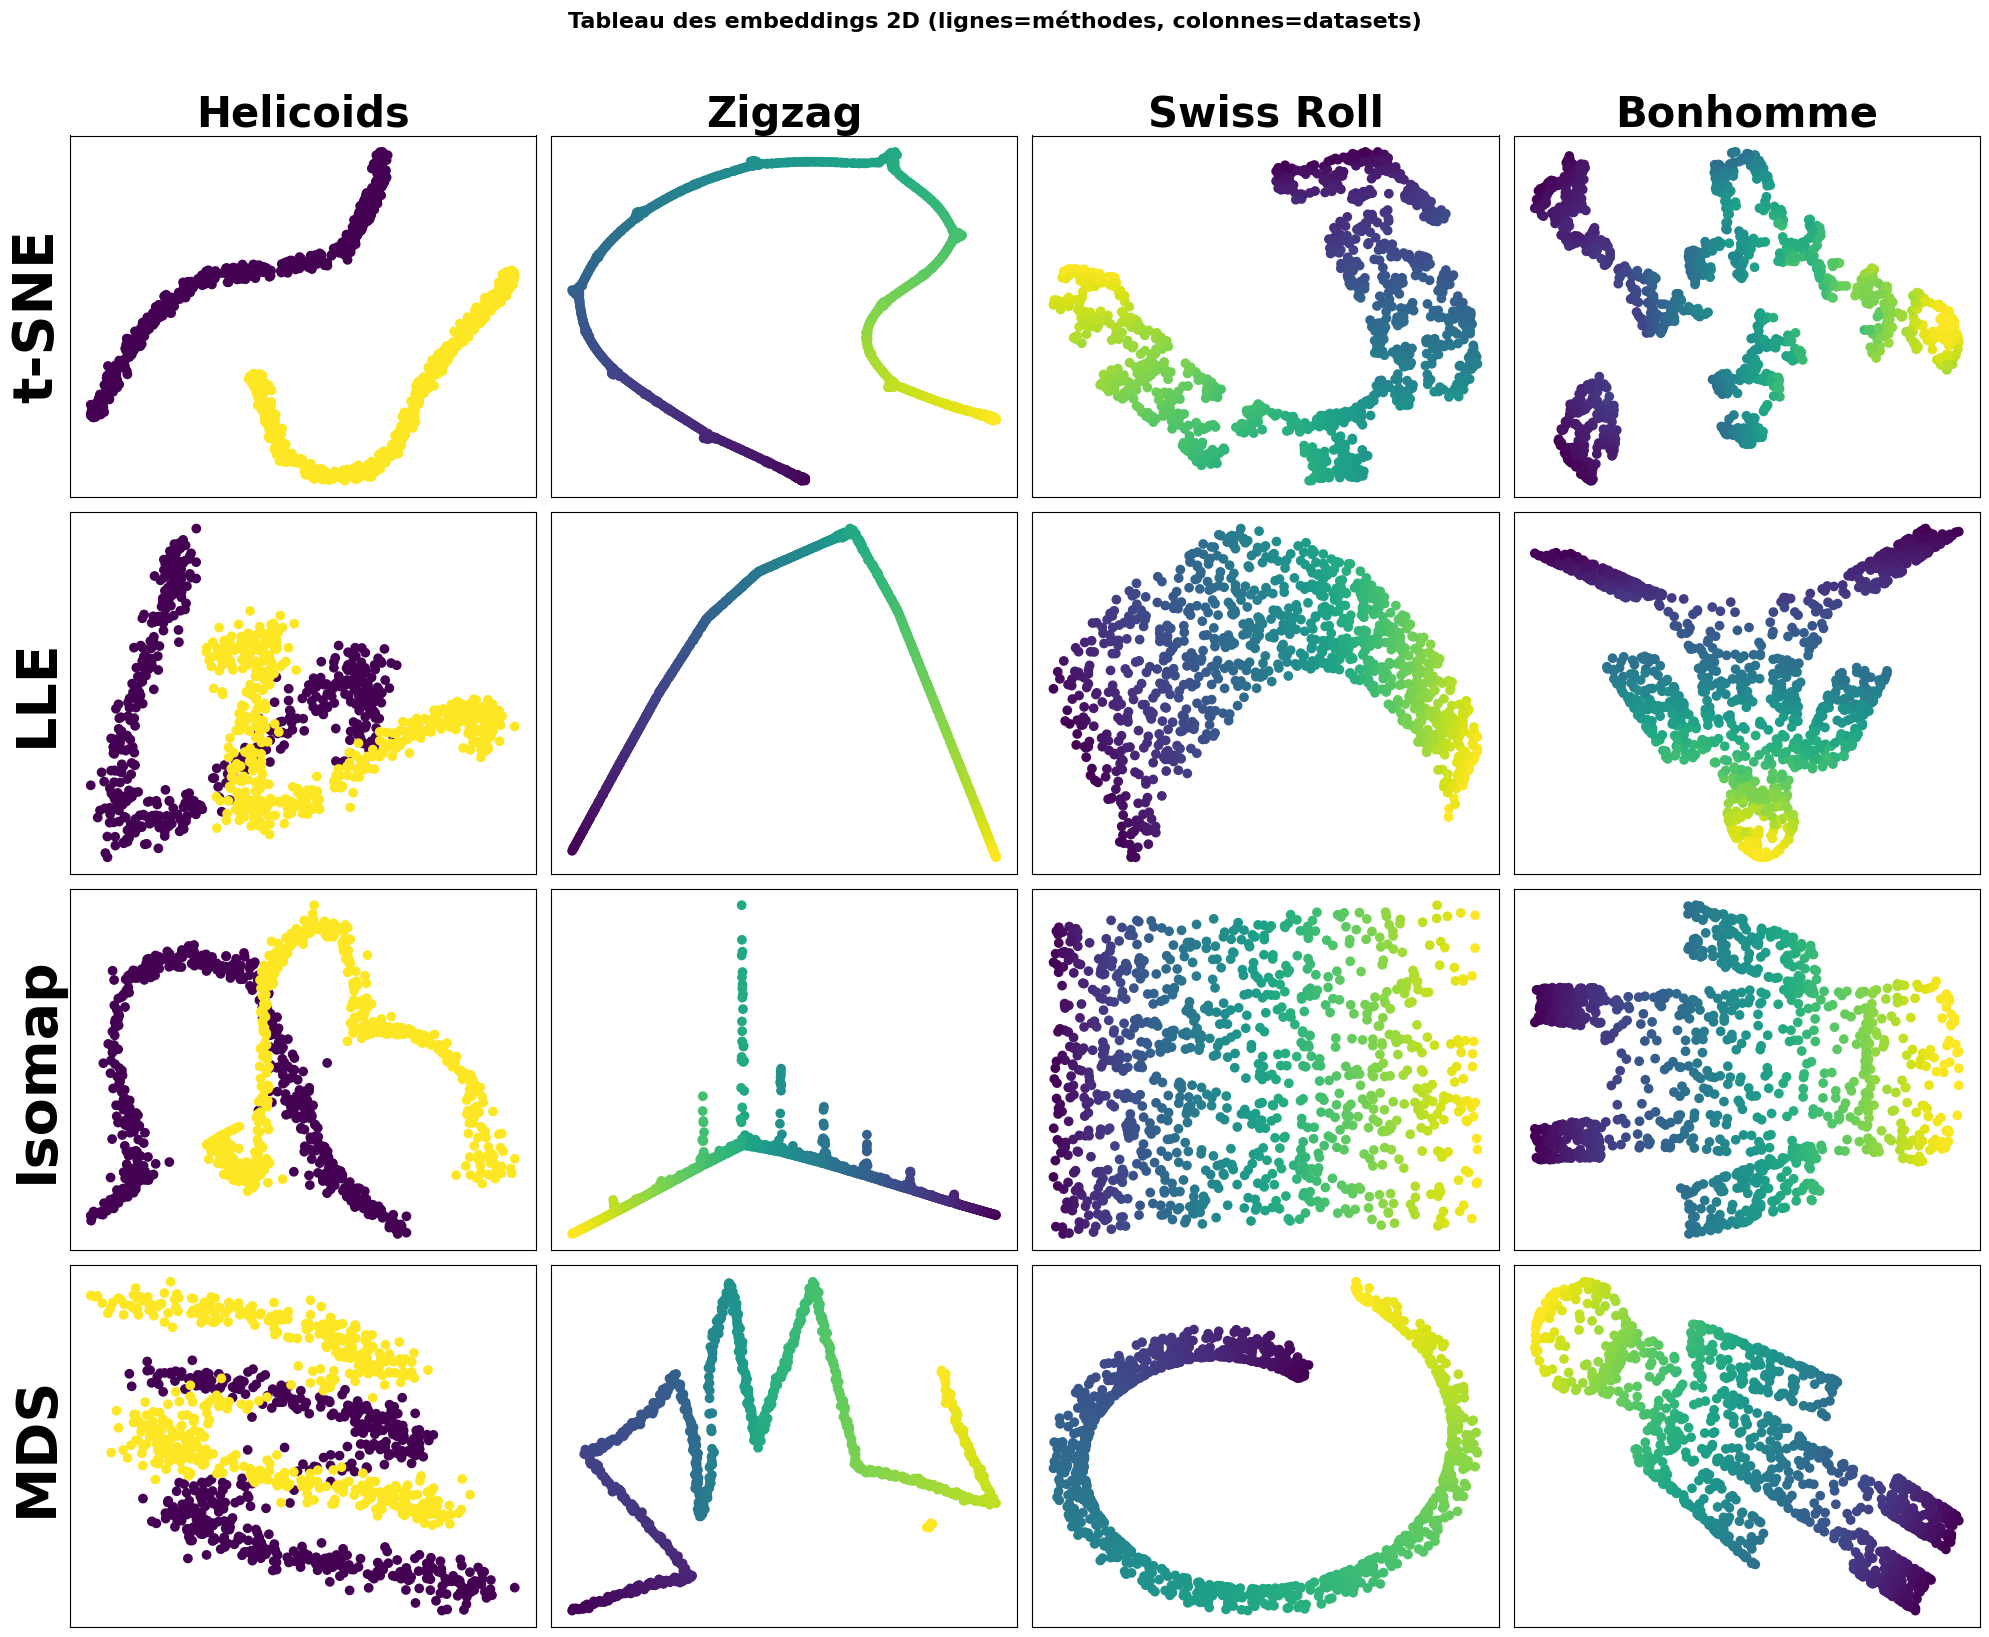

In [183]:
plot_all_methods_and_datasets(datasets, best_isomap, best_lle)

# Real data

In [250]:
from data_utils import load_real_dataset
dataset_name = 'data_real_data.pkl'
save_path = config.DATA_DIR
manager = DatasetManager(dataset_name, save_path, load_real_dataset)
dataset = manager.load_dataset()

Loading data_real_data.pkl from local storage.


In [251]:
best_isomap =  {'Helicoids':36, 'Zigzag':12, 'Swiss Roll':35, 'Bonhomme':89, 'Real Data': 89}
best_lle = {'Helicoids':64, 'Zigzag':54, 'Swiss Roll':55, 'Bonhomme':41, 'Real Data': 89}
dataset.keys()

dict_keys(['Real Data'])

## Application of dimensionality reduction methods

In [252]:
### 25 minutes to run (pass it, result is loaded after)###
results, reduction_precomputed = evaluate_methods_on_datasets(best_isomap, best_lle, dataset, precomputed=True)
aggregated_results = aggregate_metrics(results)

#save the results
import pickle
# Assuming results and aggregated_results are correctly computed:
data_to_save = {'results': results, 'aggregated_results': aggregated_results, 'reduction_precomputed': reduction_precomputed}
with open(f'{config.DATA_DIR}/results_real_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)



In [253]:
# load the results
with open(f'{config.DATA_DIR}/results_real_data.pkl', 'rb') as f:
    data = pickle.load(f)
results = data["results"]
aggregated_results = data["aggregated_results"]
reduction_precomputed = data["reduction_precomputed"]

In [255]:
X,y = reduction_precomputed['Real Data']['isomap']
X.shape

(5357, 2)

## visualization of the results

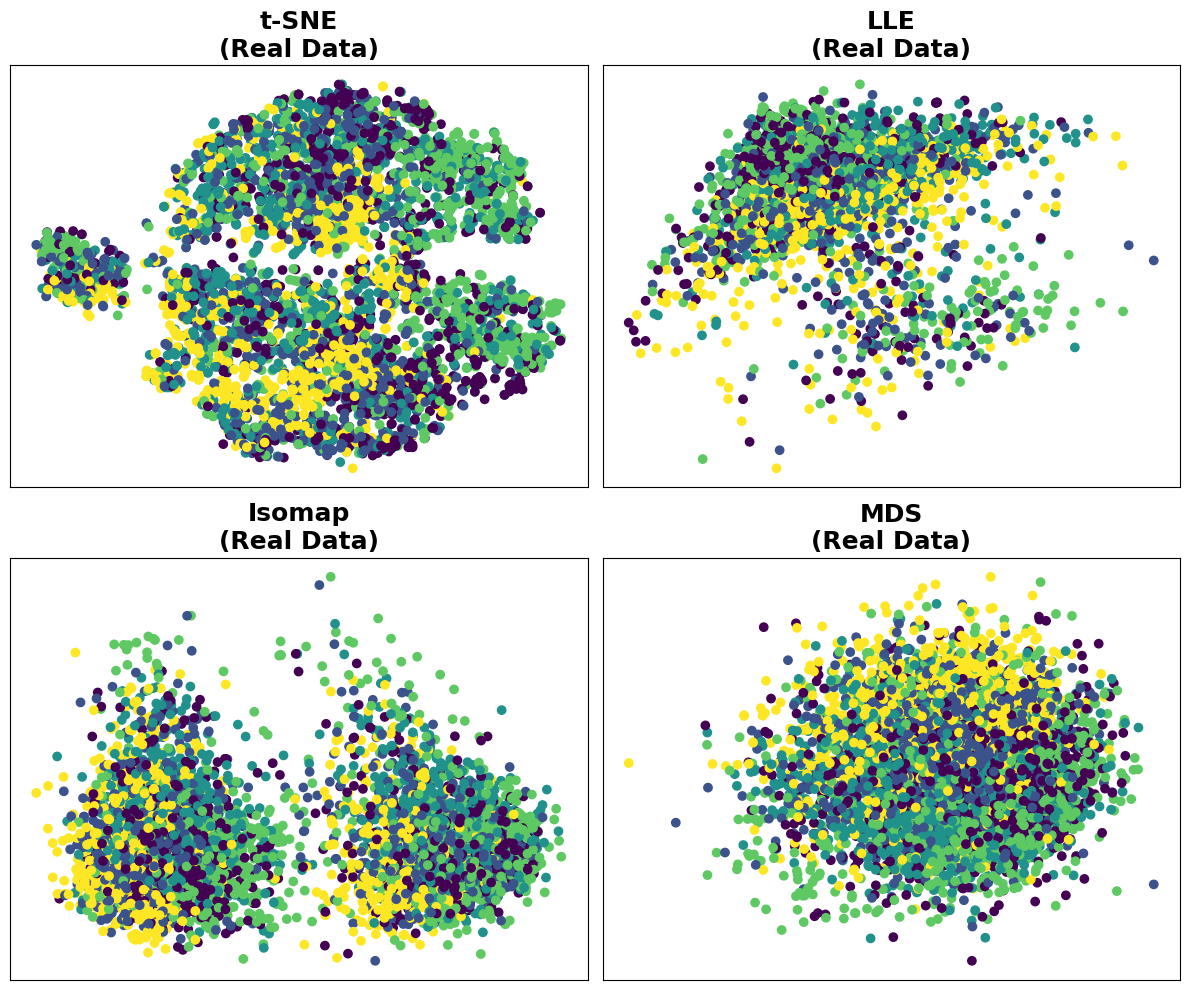

In [261]:
plot_all_methods_and_datasets(dataset, best_isomap, best_lle, precomputed=reduction_precomputed)

## print the metrics table

In [258]:
print_metrics_table(results, aggregated_results, "Real Data", "real_data_metrics")

\begin{table}[!htbp]
    \centering
    \begin{tabular}{lcccc}
        \toprule
        Metric    & t-sne & lle & isomap & mds \\
        \midrule
        $M_{t}$  & \textbf{0.989} & 0.784 & 0.801 & 0.790 \\
        $M_{c}$  & \textbf{0.959} & 0.930 & 0.949 & 0.919 \\
        $M_{class}$  & 0.297 & 0.273 & 0.252 & \textbf{0.326} \\
        Overall Score  & \textbf{0.252} & 0.338 & 0.333 & 0.321 \\
        Time  & 72.978 & \textbf{46.907} & 118.963 & 1648.607 \\
        \bottomrule
    \end{tabular}
    \caption{Quality metric scores for dataset Real Data.}
    \label{tab:real_data_metrics}
\end{table}


## Calculation of rbf classifier accuracy



In [262]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def classification_rbf_accuracy(X_low, y, train_size=0.7, random_state=None):
    """
    If y is continuous, discretize it into 10 equal-width intervals.
    Then, perform a train-test split on X_low and the discretized y,
    train a rbf SVC (one-vs-rest), and return the test accuracy.
    """
    from sklearn.preprocessing import StandardScaler
    
    # Normalize the embedding
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X_low)
    
    # Discretize continuous labels
    if np.issubdtype(y.dtype, np.floating):
        bins = np.linspace(np.min(y), np.max(y), 11)
        y_disc = np.digitize(y, bins) - 1  # yields classes 0 to 9
    else:
        y_disc = y

    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_disc, train_size=train_size, random_state=random_state
    )
    clf = SVC(kernel='rbf', decision_function_shape='ovr', random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [265]:
for method in ['isomap', 'lle', 'mds', 't-sne']:
    X,y = reduction_precomputed['Real Data'][method]
    print(method, classification_rbf_accuracy(X,y))

isomap 0.35199004975124376
lle 0.3271144278606965
mds 0.375
t-sne 0.4085820895522388
